# GLM all file ploter

In [6]:
os.getcwd()

'/home/ag-schmitz-nwfz/yota/project/GLM'

In [26]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from Helper_functions import *

# Connectivity imports
import pandas as pd
import ast

# data file names
cam_files_name = 'cam0_'
working_dir = '/home/ag-schmitz-nwfz/yota/project'#'\\\\wsl.localhost\\Ubuntu\\home\\ag-schmitz-nwfz\\yota\\project'

# Session information
sampling_rate = 30000 # Hz
camara_sampling_rate = 200 # Hz
time_bin_width = 0.005 # s
diff_TTL_usual_value = 150 # ?
n_cam_switch = 9 # number of camara switches for each session
n_ROIs = 6
ROI_names = ["Wheel", "Vibrissae", "Nose", "Pupil", "Mouth", "Paw"]

# GLM Parameters
GLM_type = "binary_binary"
coef_save_path =  \
    os.path.join(working_dir, 'GLM', 'output_files', 'GLM_coef.npy')
all_GLM_coef = np.load(coef_save_path, allow_pickle=True).item()

# Get valid periods and thresholds
all_awake_periods = np.load(os.path.join(working_dir,'GLM', 'output_files', 'valid_periods.npy'), 
                            allow_pickle=True).item()

all_thresholds = np.load(os.path.join(working_dir,'GLM', 'output_files','thresholds.npy'),
                         allow_pickle=True).item()

# Connectivity
connectivity = pd.read_csv(os.path.join(working_dir,'synaptic_connection', 'results_connectivity',
                                        'cluster_pair_info_with_connectivity_info_all_exp.csv'))
connectivity['spike_bundle_indx_pair'] = connectivity['spike_bundle_indx_pair'].apply(ast.literal_eval)
ROI_con = ROI_names.index('Vibrissae')

# Get data
path_2_spike_bundle =  \
    os.path.join(working_dir, 'data-single-unit')

experiments = [exp for exp in os.listdir(path_2_spike_bundle)
               if exp[:2] == "20" and exp[:10] in all_awake_periods
               and not all_thresholds[exp[:10]][1] == 0]
experiments.sort()

In [57]:
# GLM All file array
i = 0
all_unit_colors = np.array([])
unconnected_pair = []
connected_pair = []

# file loop
for exp in experiments:
    if True: #exp == '2023-03-21_16-17-18'
        try:
            ## IMPORT SPIKE DATA
            Spke_Bundle, spiketimes, camera_change_times, SIN_data = \
                import_spike_data(exp, working_dir, path_2_spike_bundle)
            
            ## IMPORT BEHAVIOR DATA
            Behavior = import_behavior(exp, working_dir)
            
            ## GLM PIPELINE
            
            awake_periods = all_awake_periods[exp[:10]]
            thresholds = [th / 3 for th in all_thresholds[exp[:10]]]
            
            # Get valid units and unit type
            valid_cluster_indx, cluster_type, unit_colors = \
                get_valid_cluster(Spke_Bundle, SIN_data)            

            # Save to array
            if i == 0:
                all_GLM_coef_array = all_GLM_coef[exp[:10]]
                i = 1
            else:
                all_GLM_coef_array = np.append(all_GLM_coef_array, 
                                               all_GLM_coef[exp[:10]], axis=0)
            all_unit_colors = np.append(all_unit_colors, unit_colors, axis=0)
            
            # Connectivity analisis
            connectivity_exp = connectivity[connectivity['exp_name'] == exp]
            valid_cluster_indx = np.array(valid_cluster_indx)

            for p, pair in enumerate(connectivity_exp['spike_bundle_indx_pair']):

                # Get valid pairs' coefs
                if pair[0] in valid_cluster_indx and pair[1] in valid_cluster_indx:
                    pair_indx = [np.argwhere(valid_cluster_indx == pair[j])[0] for j in [0,1]]
                    coef_pair = [all_GLM_coef[exp[:10]][pair_indx[j], ROI_con] for j in [0,1]]
                    
                    if connectivity_exp['connection'].iloc[p]:
                        connected_pair.append(coef_pair)
                    else:
                        unconnected_pair.append(coef_pair)
        
        except:
            print("\n Error when processing file " + exp[:10])


 Error when processing file 2023-04-13

 Error when processing file 2023-08-10

 Error when processing file 2023-08-10


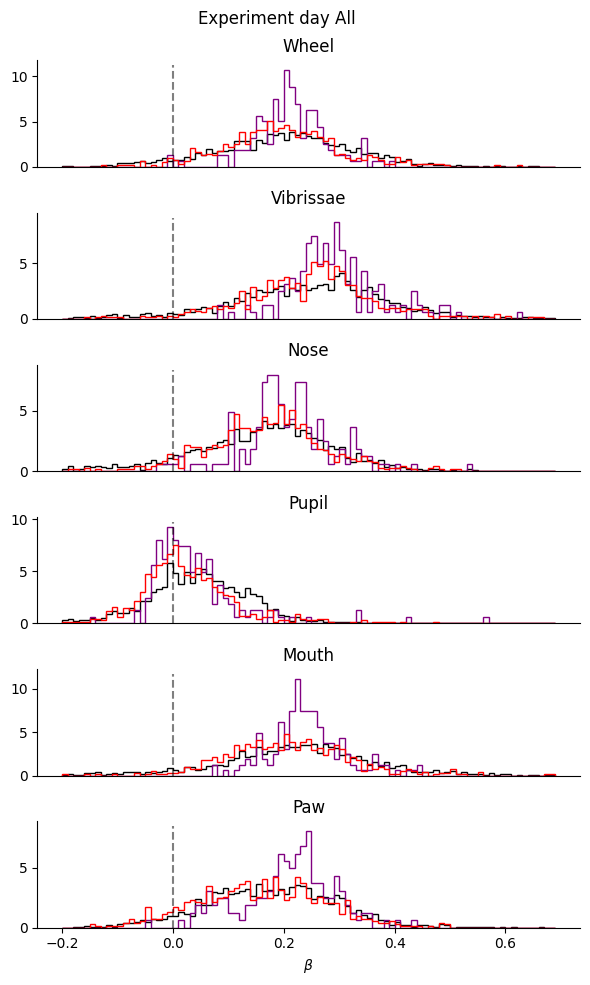

In [58]:
costume_bins = np.arange(-0.2, 0.7, 0.01)
plot_histogram_of_GLM(all_GLM_coef_array, ROI_names, all_unit_colors,
                      bins = costume_bins, exp = "All       ")

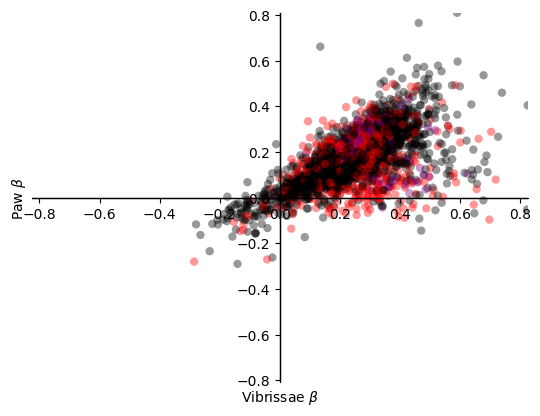

In [59]:
ROIs_to_plot = ["Vibrissae", "Paw"]

plot_scatter_of_GLM(all_GLM_coef_array[:, ROI_names.index(ROIs_to_plot[0])],
                    all_GLM_coef_array[:, ROI_names.index(ROIs_to_plot[1])], 
                    all_unit_colors, ROIs_to_plot)

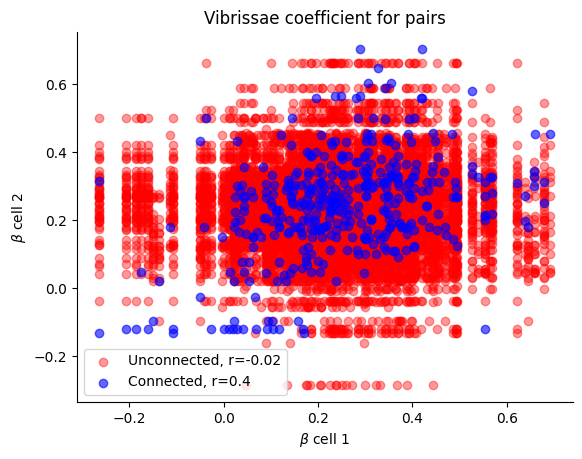

In [62]:
connected_pair_array = np.array(connected_pair).squeeze()
corr_con = np.round(np.corrcoef(connected_pair_array.T)[1,0], 2)
unconnected_pair_array = np.array(unconnected_pair).squeeze()
uncorr_con = np.round(np.corrcoef(unconnected_pair_array.T)[1,0], 2)


plt.scatter(unconnected_pair_array[:, 0], unconnected_pair_array[:, 1], color="red", alpha=0.4)
plt.scatter(connected_pair_array[:, 0], connected_pair_array[:, 1], color="blue", alpha=0.6)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.xlabel(f"$\\beta$ cell 1")
plt.ylabel(f"$\\beta$ cell 2")
plt.legend(["Unconnected, r=" + str(uncorr_con), "Connected, r=" + str(corr_con)])
plt.title(ROI_names[ROI_con] + " coefficient for pairs")
plt.show()